In [1]:
import torch
#import lattice
from torch.utils.cpp_extension import load
lattice = load(name="lattice",sources=["lattice.cpp"])
import glob

/home/marc/anaconda3/lib/python3.6/site-packages/torch/utils/cpp_extension.py:118: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) may be ABI-incompatible with PyTorch!
Please use a compiler that is ABI-compatible with GCC 4.9 and above.
See https://gcc.gnu.org/onlinedocs/libstdc++/manual/abi.html.

See https://gist.github.com/goldsborough/d466f43e8ffc948ff92de7486c5216d6
for instructions on how to install GCC 4.9 or higher.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(ABI_INCOMPATIBILITY_WARNING.format(compiler))


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
def read_img(filename):
    img = Image.open(filename).convert('RGB')
    img = np.array(img).astype(float)/255
    return img

In [4]:
paths = glob.glob('./images/*.bmp')
print(paths)

['./images/bilateral_out_2.bmp', './images/output.bmp', './images/filtered_grey.bmp', './images/input.bmp', './images/bilateral_out_1.bmp', './images/gray_original.bmp', './images/small_input.bmp']


In [5]:
img = read_img('./images/input.bmp')
filtered_img = read_img('./images/bilateral_out_1.bmp')
sigma_p = .1
sigma_c = .2

In [6]:
h,w,c = img.shape

In [7]:
position = np.mgrid[:h,:w].transpose((1,2,0))/np.sqrt(h**2+w**2)

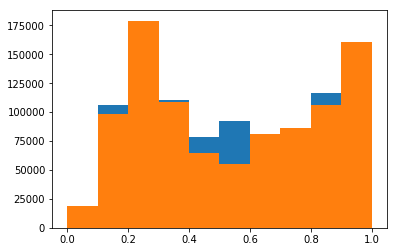

In [8]:
for i in range(2):
    plt.hist(img[...,i].reshape(-1))
plt.show()

In [9]:
reference = np.zeros((h,w,2))
#reference[...,:c] = img/sigma_c
#reference[...,c:] = position/sigma_p
reference = position/sigma_p
homo_src = np.ones((h,w,c+1))
homo_src[...,:c] = img

In [10]:
ref_arr = torch.from_numpy(reference.reshape((h*w,-1)).astype(np.float32))

In [11]:
src_arr = torch.from_numpy(homo_src.reshape((h*w,-1)).astype(np.float32))

In [12]:
src_arr

tensor([[0.7176, 0.6824, 0.6941, 1.0000],
        [0.7059, 0.6824, 0.6824, 1.0000],
        [0.7059, 0.6863, 0.6706, 1.0000],
        ...,
        [0.3059, 0.2863, 0.2745, 1.0000],
        [0.2980, 0.2784, 0.2667, 1.0000],
        [0.2941, 0.2706, 0.2706, 1.0000]])

In [13]:
ref_arr

tensor([[0.0000, 0.0000],
        [0.0000, 0.0069],
        [0.0000, 0.0139],
        ...,
        [8.3136, 5.5262],
        [8.3136, 5.5331],
        [8.3136, 5.5401]])

In [14]:
b = lattice.filter(src_arr,ref_arr)
a = b[:,:c]/(b[:,-1][:,None])

In [15]:
b[...,-1]

tensor([5135.3647, 5135.3647, 5135.3647,  ..., 5135.3647, 5135.3647,
        5135.3647])

In [16]:
ref = torch.rand(65536, 4)
src = torch.rand(65536, 4)
print(src)
print(lattice.filter(src,ref))

tensor([[0.3335, 0.8238, 0.4145, 0.3834],
        [0.9778, 0.4442, 0.3414, 0.4941],
        [0.4649, 0.6089, 0.8580, 0.2800],
        ...,
        [0.0806, 0.6253, 0.5845, 0.1641],
        [0.1793, 0.1726, 0.3884, 0.6895],
        [0.5999, 0.9011, 0.4165, 0.4091]])
tensor([[109.5504, 111.1670, 111.2637, 111.9344],
        [116.5304, 118.0829, 118.2113, 118.8214],
        [119.3937, 120.8071, 120.8826, 121.4085],
        ...,
        [ 94.9640,  96.1263,  96.5718,  97.0883],
        [ 94.9640,  96.1263,  96.5718,  97.0883],
        [ 94.9640,  96.1263,  96.5718,  97.0883]])


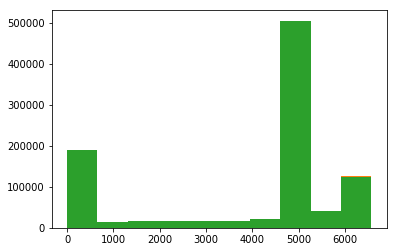

In [17]:
for i in range(3):
    plt.hist(b[...,i])
plt.show()

In [18]:
print(a.sum(0),b.sum(0))

tensor([nan, nan, nan]) tensor([3879140608., 3878878720., 3878334208., 3877606400.])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


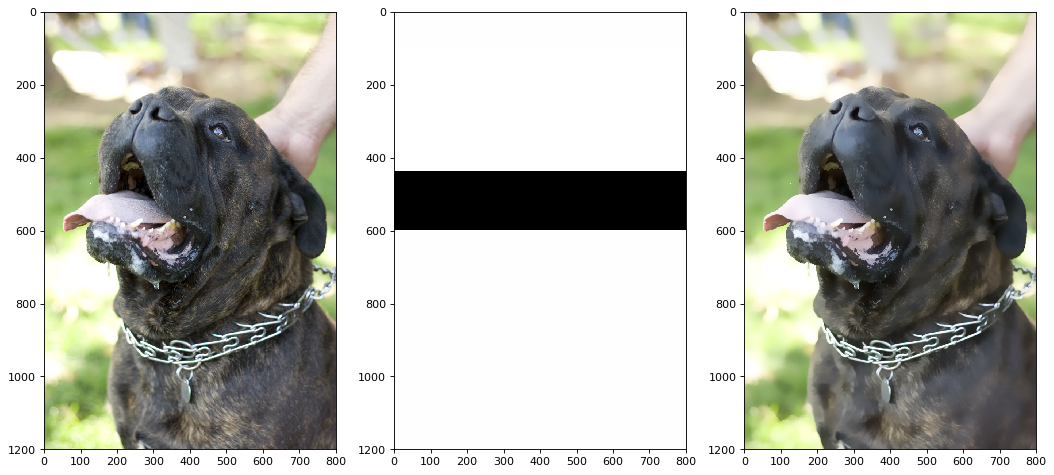

In [19]:
f,axes = plt.subplots(1,3,figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
axes[0].imshow(img)
axes[1].imshow(a.numpy().reshape((h,w,c)))
axes[2].imshow(filtered_img)
plt.show()

In [ ]:
a.numpy().reshape((h,w,c))